In [80]:
#### marbles example

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
from pymc.Matplot import plot as pmplot
import scipy.stats as sps

sns.set()

In [ ]:
df = pd.DataFrame({'prior': [0.00,0.25,0.50,0.75,1.00],
                  'ways' : [0,3,8,9,0]})

df['posterior_w_flat_prior'] = df['ways'] / df['ways'].sum()

df['prod_p_x_ways'] = df['prior'] * df['ways']

df['posterior_w_prior'] = df['prod_p_x_ways'] /df['prod_p_x_ways'].sum()


df

In [ ]:
df.plot(x='prior',y=['posterior_w_prior','posterior_w_flat_prior'],style='x--')

In [ ]:
import scipy.stats as sps

grid_size = 20
p_grid = np.linspace(0,1,grid_size)

prior = np.ones_like(p_grid)
#prior = p_grid

k = 6 # number of blue
n = 9 # in n draws

likelihood = sps.binom.pmf(k,n,p_grid)

posterior = prior * likelihood
posterior /= sum(posterior)
posterior

In [ ]:

def loss(posterior,d):
    result = np.zeros_like(d)
    
    for i in range(len(d)):
        result [i] = (posterior * np.abs(d[i] - p_grid)).sum()
        
    return result

d = np.linspace(0,1,grid_size)

l = loss(posterior,d)

plt.plot(d,l,label='loss')
plt.plot(d,posterior,label='posterior')
plt.legend(loc='upper center')

In [ ]:
### vectorize works ok with only one vector parameter
def loss2(d):
    
    return np.sum(posterior * np.abs(d - p_grid))

l = np.vectorize(loss2)(d)
print (l)

plt.plot(d,l)
    

In [ ]:
print (p_grid)
print ()
print (posterior)

plt.plot(p_grid,likelihood,'x--',label='likelihood')
plt.plot(p_grid,prior,'x--',label='prior')
plt.plot(p_grid,posterior,'x--',label='posterior')
plt.legend(loc='upper left')

In [ ]:
plt.plot(p_grid,posterior,'x--')
plt.xlabel('ratio of blue in conjecture')
plt.ylabel('Probability getting {} blue out of {}'.format(k,n))



In [ ]:
# sample from grid posterior
nr_samples = 100000

samples = np.random.choice(p_grid,replace=True,size=nr_samples,p=posterior)
plt.hist(samples,weights=np.ones_like(samples) / len(samples))
plt.xlabel('ratio of blue marbles given n = {} and k = {}'.format(n,k))
plt.ylabel('probability')

In [ ]:

#### NOTE - USING SAMPLES AS probability distribution!!! ### 
foo = pm.rbinomial(9,p=samples)
print (foo)
plt.hist(foo)


In [ ]:
import pymc as pm
from pymc.Matplot import plot as pmplot

p = pm.Uniform('p',lower=0,upper=1)

n = 3
k = 2

obs = pm.Binomial('obs',n,p,observed=True,value=[k])

model = pm.Model([p,obs])

map_ = pm.MAP(model)
map_.fit()

print (map_[0]) # first (and only param in model)

mcmc = pm.MCMC(model)
mcmc.sample(10000,1000,2)

p_post = mcmc.trace(p)[:]

pmplot(p_post,'p_post')

result = pd.DataFrame({'p_post': p_post})

plt.figure(figsize=(18,12))
plt.axvline(0,color='r',ls='dashed',label='ratio blue marbles in each of 5 conjectures')
plt.axvline(0.25,color='r',ls='dashed')
plt.axvline(0.50,color='r',ls='dashed')
plt.axvline(0.75,color='r',ls='dashed')
plt.axvline(1.0,color='r',ls='dashed')

plt.xlabel('posterior (most plausible) ratio blue marbles with n = {:.0f} k = {:.0f}'.format(n,k))
plt.ylabel('probability')
plt.legend(loc='upper center')

plt.hist(result.p_post, weights=np.ones_like(result.p_post) / len(result.p_post))

result.describe()



In [ ]:
print (sum(np.array([0,1,2,3,4,5]) / sum(np.arange(0,6))))

In [ ]:
### Metropolis-Hastings algorithm
###
### example distribution
#https://stephens999.github.io/fiveMinuteStats/MH_intro.html
# π(x)=exp(−x)(x≥0) distribution to sample from 


def my_exp_dist(x):
    lambda_ = 2

    return 0 if x < 0 else lambda_ * np.exp(-x*lambda_) ### def of pdf for exponential distribution

def my_gauss_dist(x):
    mu = 0
    sigma = 1
    
    return 1 / (sigma * (2 * np.pi) ** 0.5) * np.exp(-0.5 * ( (x-mu) / sigma ) ** 2 )

def my_weird_dist(x): #must sum to 1, x in range 0..5
    
    if (x < 0) or (x > 5): #pretend dist only defined between 0..5
        return 0
    else:
        return (x / sum([0,1,2,3,4,5])) #sums to 1 for the range of independent values [0..5]


### select distribution ###
target = my_weird_dist
### ### ### ### ### ### ###

x = np.linspace(0,5,6)
f = np.zeros_like(x)

for i in range(len(x)):
    f[i] = target(x[i])
    

plt.figure(figsize=(18,12))   
plt.plot(x,f,'o--')
plt.title('A weird homemade probability distribution for 6 discrete outcomes')
plt.xlabel('outcome')
plt.ylabel('probability')
plt.savefig('MH-homemade_dist.jpg',format='jpg')

In [ ]:
# Information entropy
#data = np.array([0.3,0.7])
data = f
print (data)
data = data[1:]
ie = -sum(data * np.log(data)) #if first prob is zero, skip it
ie

In [ ]:
### Metropolis-Hastings MCMC algorithm

# 'target' is a probability distribution, that is, a function that sums to 1,
# here implemented as a Python function.
# 

size = 20 # length of MCMC random sampling

walk = np.zeros(size) # array of samples 

all_proposed = np.zeros(size)
all_current = np.zeros(size)

walk[0] = 3 #initialize first step with dummy value to get MCMC walk started

# the random walk
for i in range(1,size):
    current = walk[i-1]
    all_current[i] = current
    proposed = current + pm.rnormal(0,1/ 1**2)
    all_proposed[i] = proposed
    
    A = target(proposed) / target(current) # accept ?
    
    # ratio above expresses ratio of probabilities for proposed outcome vs current outcome, accoriding to distribution
    # if ratio > 1 : accept always. if ratio < 1, accept if ratio > random number 0..1
    
    # For proposals outside domain of independent variable, i.e the outcome, for instance, if current is 5, 
    # that is, domain max of independent variable , and proposed is 6,
    # then, since all values outside of domain for the independent have p==0, that proposal is not accepted. 
    # This can be seen in the trace plot, where proposals occur outside of domain [0..5], but are never accepted. 
    
    if pm.runiform(0,1) < A : 
        walk[i] = proposed # accept
    else:
        walk[i] = current
        
plt.figure(figsize=(18,12))
plt.title('Metropolis-Hastings random sampling walk')
plt.xlabel ('step number')
plt.ylabel('from unknown probability distribution sampled value')
plt.plot(walk,'o--',label='accepted',color='navy',alpha=1)
plt.plot(range(1,len(all_proposed)),all_proposed[1:],'o',color='orange',label='proposed',alpha=1)
plt.legend(loc='upper left')
plt.savefig('MH-random-sampling-walk.jpg',format='jpg')



In [ ]:
plt.figure(figsize=(18,12))
plt.title('Samples obtained by Metropolis-Hastings from given probability distribution')
plt.xlabel('sampled outcome')
plt.ylabel('Relative Frequency')
_=plt.hist(walk,bins=[0,1,2,3,4,5,6],weights=np.ones_like(walk) / len(walk))
plt.savefig('MH-posterior-samples.jpg',format='jpg')

 [-----------------100%-----------------] 200000 of 200000 complete in 5.3 secPlotting deaths_post


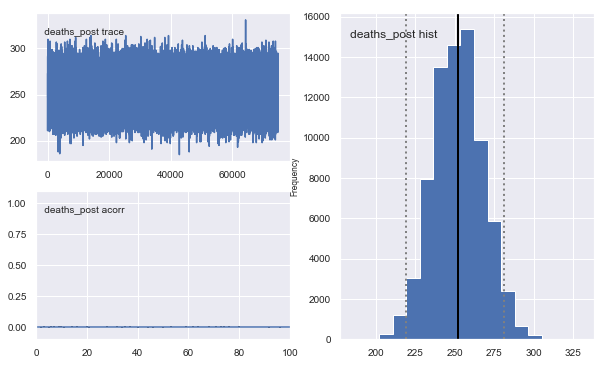

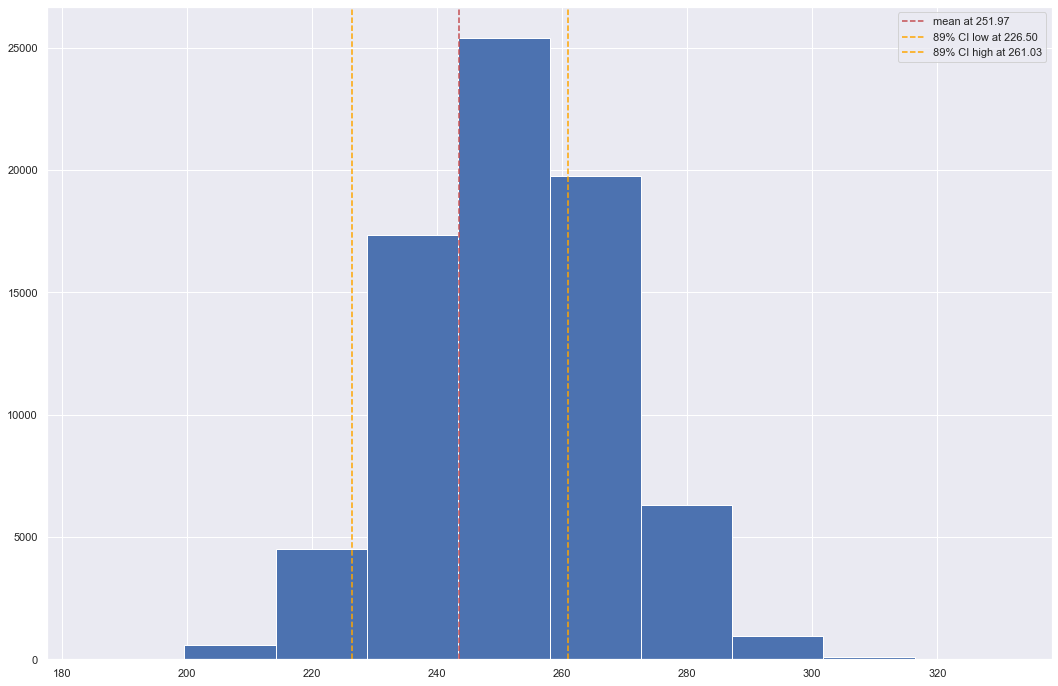

In [15]:
# expected daily deaths sweden 252

lambda_ = 252.
deaths = pm.Poisson('deaths',lambda_)

model = pm.Model([deaths])
map_ = pm.MAP(model)

mcmc = pm.MCMC(model)
samples = mcmc.sample(200000,50000,2)

deaths_post = mcmc.trace('deaths')[:]
pmplot(deaths_post,'deaths_post')

result = pd.DataFrame({'deaths_post' : deaths_post})

plt.figure(figsize=(18,12))
result.describe()
_= plt.hist(result.deaths_post)

nr_rows = 10

sample_rows = np.random.choice(result.index,replace=True,size=nr_rows)
samples = result.loc[sample_rows]

ci_89 = np.percentile(samples.deaths_post,[5.5,94.5])

plt.axvline(samples.deaths_post.mean(),color='r',ls='dashed',label='mean at {:.2f}'.format(result.deaths_post.mean()))
plt.axvline(ci_89[0],color='orange',ls='dashed',label='89% CI low at {:.2f}'.format(ci_89[0]))
plt.axvline(ci_89[1],color='orange',ls='dashed', label='89% CI high at {:.2f}'.format(ci_89[1]))
plt.legend(loc='upper right')

In [18]:
# matrix grid approx

df = pd.read_csv('../Stat_Rethink/Howell1.csv',sep=';')


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0
542,71.120,8.051258,0.0,1


In [76]:
grid_step = 1

# 200 * 50 matrix, gives 10000 rows of combinations mu,sigma

grid = np.mgrid[1:5:grid_step,5:10:grid_step].reshape(2,-1).T
grid = pd.DataFrame(grid)
grid.columns=[['mu','sigma']]
grid

,mu,sigma
0,1,5
1,1,6
2,1,7
3,1,8
4,1,9
5,2,5
6,2,6
7,2,7
8,2,8
9,2,9


In [99]:
def foo(mu,sigma):
    return sps.norm.pdf(np.linspace(-2,2,10),mu,sigma)

bar = grid.apply(lambda x : foo (x['mu'], x['sigma']),axis=1)
bar

0     [0.06664492057835994, 0.07001864399644354, 0.0...
1     [0.05867755446071659, 0.06072471790104302, 0.0...
2     [0.05199096024506909, 0.053317527609363605, 0....
3     [0.04648188673372112, 0.047387232105570505, 0....
4     [0.04193146974366591, 0.04257546685295424, 0.0...
5     [0.05793831055229655, 0.06196311738650997, 0.0...
6     [0.053241334253725375, 0.055783285759228286, 0...
7     [0.048406847965255365, 0.050094280939705145, 0...
8     [0.04400816584553744, 0.04517797873534295, 0.0...
9     [0.04015820332030484, 0.04099931190751741, 0.0...
10    [0.04839414490382867, 0.05268427926869336, 0.0...
11    [0.04698531256838376, 0.049840104199836976, 0....
12    [0.04415934440272378, 0.04611509832087278, 0.0...
13    [0.041020121068796885, 0.04240395840307268, 0....
14    [0.03798803268512547, 0.038997077082341236, 0....
15    [0.0388372109966426, 0.04303849220060621, 0.04...
16    [0.04032845408652389, 0.043310186717261036, 0....
17    [0.039470740790642965, 0.04159441092975135

In [83]:
df = pd.DataFrame({'a_col':[1,2,3,4],
                   'b_col': [5,6,7,8]})

df

,a_col,b_col
0,1,5
1,2,6
2,3,7
3,4,8


In [96]:
def foo(a,b):
    return a * b

In [98]:
df.apply(lambda row : foo(row['a_col'],row['b_col']),axis=1)


0     5
1    12
2    21
3    32
dtype: int64